In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import os
import astropy.io.fits as fits
from astropy.table import Table
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask
from desiutil.plots import prepare_data, init_sky, plot_sky_circles, plot_sky_binned
from desiutil.log import get_logger
import warnings
import mpl_toolkits
%matplotlib inline

In [2]:
def qadensity(cat, objtype, targdens=None, max_bin_area=10.0):
    label = '{} (targets/deg$^2$)'.format(objtype)
    if targdens:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots(1)
    ax = np.atleast_1d(ax)
    
    basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
    basemap, data = plot_sky_binned(cat['RA'], cat['DEC'], max_bin_area=max_bin_area,
                                    clip_lo='!1', cmap='jet', plot_type='healpix', 
                                    label=label, basemap=basemap, return_grid_data=True)
    if targdens:
        dens = data[np.nonzero(data)]
        ax[1].hist(dens, bins=40, histtype='stepfilled', alpha=0.6, label='Observed {} Density'.format(objtype))
        if objtype in targdens.keys():
            ax[1].axvline(x=targdens[objtype], ls='--', color='k', label='Goal {} Density'.format(objtype))
        ax[1].set_xlabel(label)
        ax[1].set_ylabel('Number of Healpixels')
        ax[1].legend(loc='upper left', frameon=False)
        fig.subplots_adjust(wspace=0.2)
    return dens

These are some of the questions we want to address by exploring the simulation outputs from the `quicksurvey2017` run.

### BGS
* New redshifts obtained per month versus time. Also subdivided into by pass (1,2 or 3).
* The above separately for r<19.5 and 19.5<r<20 targets
* Distribution of exposure times
* The fraction of targets that receive a fibre versus 
    - magnitude (presumably just a step function at 19.5); 
    - density on the sky (either Healpix or the tile) 
    - RA 
    - dec 
    - galactic latitude 
    - stellar density
* The above separately for r<19.5 and 19.5<r<20 targets
* Redshift success rate versus exposure time  

In [5]:
topdir = os.path.join("/global/cscratch1/sd/forero/quicksurvey2017b/")
program = 'bright'
epoch = 34

truthfile = os.path.join(topdir, 'targets/{}/truth.fits'.format(program))
targetfile = os.path.join(topdir, 'targets/{}/targets.fits'.format(program))
zcatfile = os.path.join(topdir, 'zcat/{}/{}'.format(program,epoch), 'zcat.fits')
mtlfile = os.path.join(topdir, 'zcat/{}/{}'.format(program,epoch), 'mtl.fits')

In [6]:
targets  = fits.getdata(targetfile)
truth = fits.getdata(truthfile)
zcat = fits.getdata(zcatfile)
mtl = fits.getdata(mtlfile)

In [7]:
Table(mtl[0:1])

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,PRIORITY
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,float64,int32,int32,int64
0,0425p057,0,42.5188293457,5.81632900238,9.43747,13.4167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75205,0.82535,0.8974,0.983819,0.990031,288230376151711744,1152921504606846976,65537,0,0,0.54591057572,7,1,2000


In [8]:
Table(zcat[0:1])

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
288230376151711750,,GALAXY,0.248714,5.41471e-05,0,3


In [9]:
Table(truth[0:1])

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
288230376151711744,3344679,0,0.47535,GALAXY,BGS,,-1,4083286876,19.6809,9.43747,13.4167,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
Table(targets[0:1])

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,float64,int64
0,0425p057,0,42.5188293457,5.81632900238,9.43747,13.4167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75205,0.82535,0.8974,0.983819,0.990031,288230376151711744,1152921504606846976,65537,0,0,0.54591057572,7


In [11]:
print(set(zcat['SPECTYPE']))

{'GALAXY', 'STAR'}


/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


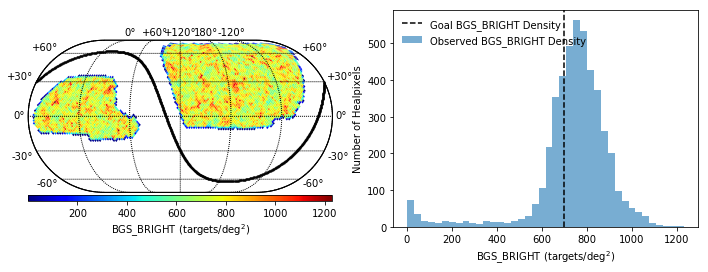

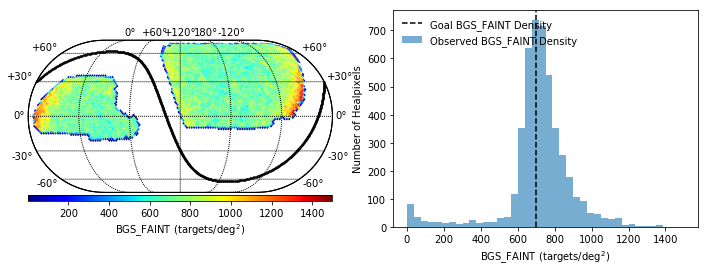

In [17]:
targdens = {'BGS_BRIGHT':700, 'BGS_FAINT':700}
for obj in ['BGS_BRIGHT', 'BGS_FAINT']:
    ii = (targets['BGS_TARGET'] & bgs_mask.mask(obj))!=0
    dd = targets[ii]
    a = qadensity(dd, obj, targdens=targdens)

In [31]:
bgsfaint_ii = (targets['BGS_TARGET'] & bgs_mask.mask('BGS_FAINT'))!=0
bgsfaint_targets = targets[bgsfaint_ii]

ii = np.in1d(zcat['TARGETID'], bgsfaint_targets['TARGETID'])
bgsfaint_zcat = zcat[ii]

ii = np.in1d(truth['TARGETID'], bgsfaint_targets['TARGETID'])
bgsfaint_truth = truth[ii]

In [32]:
bgsbright_ii = (targets['BGS_TARGET'] & bgs_mask.mask('BGS_BRIGHT'))!=0
bgsbright_targets = targets[bgsbright_ii]

ii = np.in1d(zcat['TARGETID'], bgsbright_targets['TARGETID'])
bgsbright_zcat = zcat[ii]

ii = np.in1d(truth['TARGETID'], bgsbright_targets['TARGETID'])
bgsbright_truth = truth[ii]

In [33]:
assert len(bgsfaint_truth) == len(bgsfaint_targets)
assert len(bgsbright_truth) == len(bgsbright_targets)

In [34]:
#efficiency as a function of redshift (using truth info)
bgsfaint_truez = bgsfaint_truth['TRUEZ']
bgsbright_truez = bgsbright_truth['TRUEZ']

n_edges = 11
n_bin = n_edges -1
zbin = np.linspace(0.0, 0.6, n_edges)
z_center = (zbin[0:-1]+zbin[1:])/2


n_in = np.ones(n_bin)
n_out_good = np.ones(n_bin)
n_out_all = np.ones(n_bin)

spectype = 'GALAXY'
for i in range(n_bin):
    ii = (bgsfaint_truth['TRUESPECTYPE']==spectype) 
    ii &= (bgsfaint_truth['TRUEZ']>zbin[i]) 
    ii &= (bgsfaint_truth['TRUEZ']<zbin[i+1])
    
    jj = (bgsfaint_zcat['ZWARN']==0) & (bgsfaint_zcat['SPECTYPE']==spectype) 
    jj &= (bgsfaint_zcat['Z']>zbin[i]) & (bgsfaint_zcat['Z']<zbin[i+1])

    kk = (bgsfaint_zcat['SPECTYPE']==spectype) 
    kk &= (bgsfaint_zcat['Z']>zbin[i]) & (bgsfaint_zcat['Z']<zbin[i+1])
    
    n_in[i] = np.count_nonzero(ii)
    n_out_good[i] = np.count_nonzero(jj)
    n_out_all[i] = np.count_nonzero(kk)

final_faint = np.array([z_center, n_in, n_out_all, n_out_good])

for i in range(n_bin):
    ii = (bgsbright_truth['TRUESPECTYPE']==spectype) 
    ii &= (bgsbright_truth['TRUEZ']>zbin[i]) 
    ii &= (bgsbright_truth['TRUEZ']<zbin[i+1])
    
    jj = (bgsbright_zcat['ZWARN']==0) & (bgsbright_zcat['SPECTYPE']==spectype) 
    jj &= (bgsbright_zcat['Z']>zbin[i]) & (bgsbright_zcat['Z']<zbin[i+1])

    kk = (bgsbright_zcat['SPECTYPE']==spectype) 
    kk &= (bgsbright_zcat['Z']>zbin[i]) & (bgsbright_zcat['Z']<zbin[i+1])
    
    n_in[i] = np.count_nonzero(ii)
    n_out_good[i] = np.count_nonzero(jj)
    n_out_all[i] = np.count_nonzero(kk)
    
final_bright = np.array([z_center, n_in, n_out_all, n_out_good])

In [37]:
bgsbright_eff = final_bright[2]/final_bright[1]
bgsfaint_eff = final_faint[2]/final_faint[1]

(0.6, 1.0)

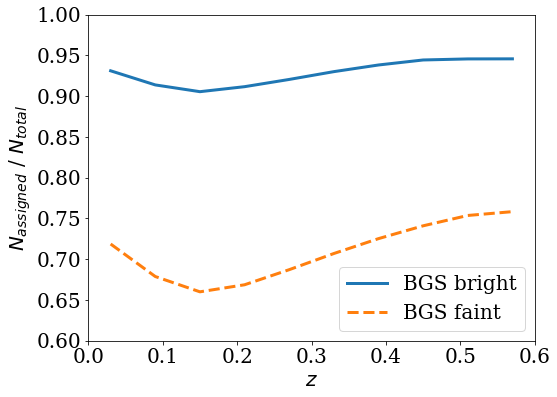

In [39]:
fig = plt.figure(1, figsize=(8,6))
plt.rc('font', family='serif', size=20)
plt.plot(z_center, bgsbright_eff, label='BGS bright', linewidth=3, linestyle='-')
plt.plot(z_center, bgsfaint_eff, label='BGS faint', linewidth=3, linestyle='--')
plt.xlabel('$z$')
plt.ylabel('$N_{assigned}$ / $N_{total}$')
plt.legend(loc=4)
plt.xlim([0,0.60])
plt.ylim([0.6,1.0])

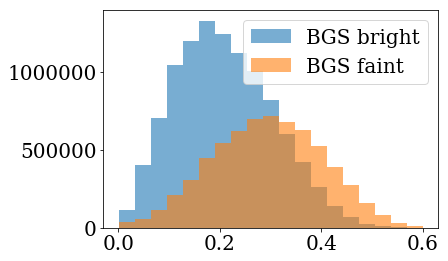

In [44]:
a = plt.hist(bgsbright_zcat['Z'], label='BGS bright',
             bins=np.linspace(1E-3,0.6,20), histtype='stepfilled', alpha=0.6)
a = plt.hist(bgsfaint_zcat['Z'], label='BGS faint',
             bins=np.linspace(1E-3,0.6,20), histtype='stepfilled', alpha=0.6)
plt.legend()

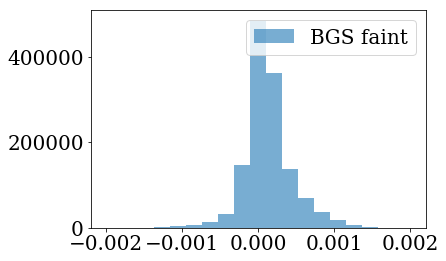

In [53]:
a = plt.hist(bgsfaint_zcat['Z'], label='BGS faint',
             bins=np.linspace(-0.002,0.002,20), histtype='stepfilled', alpha=0.6)
plt.legend()